In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import pandas as pd
df=pd.read_csv('ACC_10minute_data.csv',na_values=['null'],
               index_col='date',parse_dates=True,infer_datetime_format=True)
df.head()

/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_49423/1777501066.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv('ACC_10minute_data.csv',na_values=['null'],


,Unnamed: 0,close,high,low,open,volume
date,,,,,,
2015-02-02 09:15:00+05:30,0,1540.15,1556.70,1536.05,1554.90,12181
2015-02-02 09:25:00+05:30,1,1543.55,1549.90,1536.10,1540.15,8810
2015-02-02 09:35:00+05:30,2,1542.35,1547.05,1542.00,1543.55,8097
2015-02-02 09:45:00+05:30,3,1547.40,1548.50,1541.05,1542.35,5346
2015-02-02 09:55:00+05:30,4,1548.35,1549.95,1543.95,1547.40,4320


# **EDA**

In [3]:
df.shape

(65929, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65929 entries, 2015-02-02 09:15:00+05:30 to 2022-10-21 15:25:00+05:30
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  65929 non-null  int64  
 1   close       65929 non-null  float64
 2   high        65929 non-null  float64
 3   low         65929 non-null  float64
 4   open        65929 non-null  float64
 5   volume      65929 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 3.5 MB


In [5]:
df.isna().sum()

Unnamed: 0    0
close         0
high          0
low           0
open          0
volume        0
dtype: int64

# **Data Preprocessing**

In [6]:
df['price'] = ((df['close']+df['high']+df['low'])/3)
df['Cumulative_Price_Volume'] = (df['price'] * df['volume']).cumsum()
df['Cumulative_Volume'] = df['volume'].cumsum()
df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']
print(df)

                           Unnamed: 0    close     high      low     open  \
date                                                                        
2015-02-02 09:15:00+05:30           0  1540.15  1556.70  1536.05  1554.90   
2015-02-02 09:25:00+05:30           1  1543.55  1549.90  1536.10  1540.15   
2015-02-02 09:35:00+05:30           2  1542.35  1547.05  1542.00  1543.55   
2015-02-02 09:45:00+05:30           3  1547.40  1548.50  1541.05  1542.35   
2015-02-02 09:55:00+05:30           4  1548.35  1549.95  1543.95  1547.40   
...                               ...      ...      ...      ...      ...   
2022-10-21 14:45:00+05:30       65924  2251.50  2256.00  2247.00  2252.30   
2022-10-21 14:55:00+05:30       65925  2259.00  2259.00  2250.05  2251.50   
2022-10-21 15:05:00+05:30       65926  2256.60  2260.00  2254.00  2259.00   
2022-10-21 15:15:00+05:30       65927  2258.00  2261.30  2254.30  2256.60   
2022-10-21 15:25:00+05:30       65928  2257.00  2259.00  2255.00  2258.95   

<Axes: xlabel='date'>

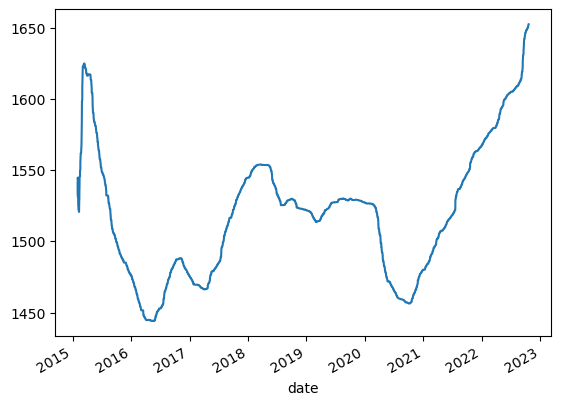

In [7]:
df['VWAP'].plot()

In [8]:
# Set Target Variable
output_var = pd.DataFrame(df['VWAP'])
#Selecting the Features
features = ['open', 'high', 'low', 'volume']

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,open,high,low,volume
date,,,,
2015-02-02 09:15:00+05:30,0.349195,0.346718,0.346461,0.005714
2015-02-02 09:25:00+05:30,0.341296,0.343102,0.346488,0.004133
2015-02-02 09:35:00+05:30,0.343117,0.341586,0.349677,0.003798
2015-02-02 09:45:00+05:30,0.342474,0.342357,0.349163,0.002508
2015-02-02 09:55:00+05:30,0.345178,0.343128,0.350731,0.002026


In [10]:
from sklearn.model_selection import TimeSeriesSplit
# Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10) # 90-10%
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [11]:
print(X_train.shape)
print(X_test.shape)

(59936, 4)
(5993, 4)


In [12]:
# Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(59936, 1, 4)
(5993, 1, 4)


# **Applying LSTM Model**

In [13]:
# Building the LSTM Model
import tensorflow as tf
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(128, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))
lstm.add(tf.keras.layers.LSTM(64, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(25))
lstm.add(tf.keras.layers.Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
tf.keras.utils.plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
# Model Training
history=lstm.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, shuffle=False)

Epoch 1/10
3746/3746 [==============================] - 4s 1ms/step - loss: 91343.9453
Epoch 2/10
3746/3746 [==============================] - 4s 1ms/step - loss: 4398.6211
Epoch 3/10
3746/3746 [==============================] - 4s 1ms/step - loss: 2813.1804
Epoch 4/10
3746/3746 [==============================] - 4s 1ms/step - loss: 1864.4447
Epoch 5/10
3746/3746 [==============================] - 4s 1ms/step - loss: 1243.1355
Epoch 6/10
3746/3746 [==============================] - 4s 1ms/step - loss: 831.6348
Epoch 7/10
3746/3746 [==============================] - 4s 1ms/step - loss: 573.2858
Epoch 8/10
3746/3746 [==============================] - 4s 1ms/step - loss: 397.6643
Epoch 9/10
3746/3746 [==============================] - 4s 1ms/step - loss: 276.0764
Epoch 10/10
3746/3746 [==============================] - 4s 1ms/step - loss: 195.9845


In [15]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

188/188 [==============================] - 0s 490us/step


In [16]:
from sklearn.metrics import mean_squared_error

# Make predictions using the trained model
predictions = lstm.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

188/188 [==============================] - 0s 468us/step
Mean Squared Error: 3172.8734243611025


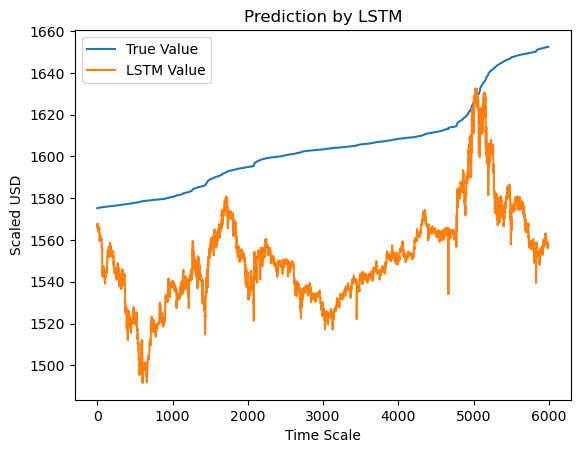

In [17]:
#Predicted vs True Close Value – LSTM
import matplotlib.pyplot as plt
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()